# llustrative example: 2D linear elasticity problem

In [1]:
# Visualization of the analytical solution
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
import numpy as np

import phd.models.cm.analytical_plate as ap
from phd.config import load_config, copy_config, apply_overrides
from phd.plot.plot_cm import plot_field

from phd.plot import get_current_config as plt_cfg, book_config, book_compact_config, A4_config
book_config.set_as_current()
page_width = plt_cfg().page_width
# Configuration
save_fig = True
save_table = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



### Implementation details: Plate under sinusoidal body-load

W0108 17:44:47.877002   18715 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0108 17:44:47.881128   18603 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


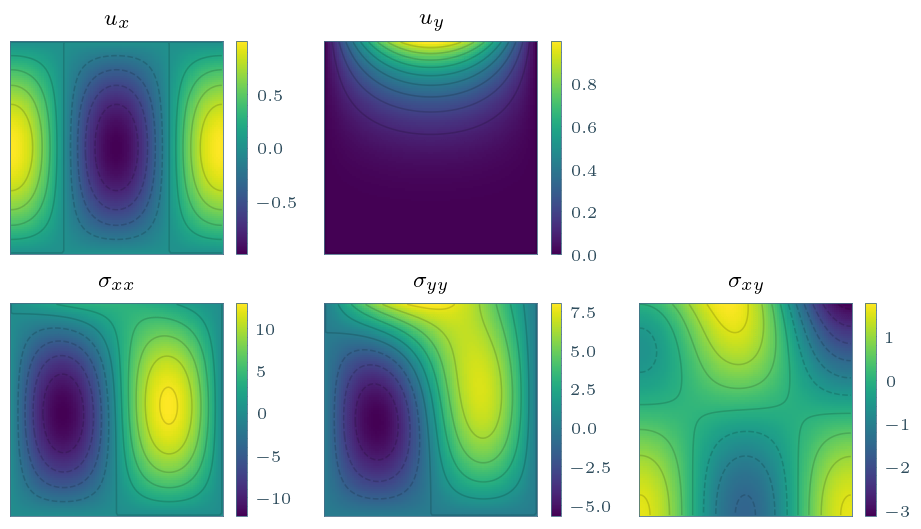

In [2]:
base_config = load_config("analytical_plate")
mat_params = base_config['problem']['material']

x_lin = np.linspace(0, 1, 100)
Xmesh, Ymesh = np.meshgrid(x_lin, x_lin, indexing="ij")
X_input = [x_lin.reshape(-1, 1), x_lin.reshape(-1, 1)]

lmbd, mu, Q = mat_params['lmbd'], mat_params['mu'], mat_params['Q']
sol = ap.exact_solution(X_input, lmbd, mu, Q)

field_names = ap.LATEX_FIELD_NAMES

fig_size = (plt_cfg().page_width, 0.57*plt_cfg().page_width)
fig, axes = plt.subplots(2, 3, figsize=fig_size, dpi=200)
axes[0, 2].set_visible(False)
axes_plot = axes[0, :-1].flatten().tolist() + axes[1, :].flatten().tolist()

for idx, field in enumerate(field_names.keys()):
    ax = axes_plot[idx]
    art = plot_field(
        ax, Xmesh, Ymesh, sol[:, idx].reshape(Xmesh.shape), cmap='viridis', plot_contours=True
    )
    fig.colorbar(art["im"], ax=ax)
    ax.set_title(field_names[field])

plt.tight_layout()

# save figure
if save_fig:
    figure_folder = "./images"
    os.makedirs(figure_folder, exist_ok=True)
    os.makedirs(figure_folder+"/pdf", exist_ok=True) 
    figure_name = "analytical_plate_solution"
    fig.savefig(os.path.join(figure_folder, figure_name + ".png"), bbox_inches='tight', dpi=300)
    fig.savefig(os.path.join(figure_folder, "pdf", figure_name + ".pdf"), bbox_inches='tight', dpi=300)

## Forward problem

In [3]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (disp.)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (disp.)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed
Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


### Comparing mixed and displacement-based formulation

Saved: './images/disp_vs_mixed_spinn.png' + .pgf


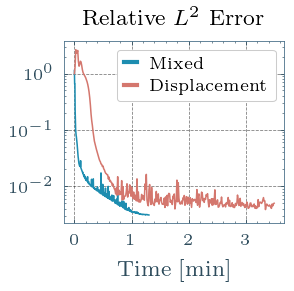

In [4]:
results_spinn = {
    k: v for k, v in results_forward.items() if "spinn" in k
}
config_text_dict_mixed = {
    "spinn_mixed": "Mixed",
    "spinn_disp": "Displacement",
}

# Plotting L2 Error for SPINN runs only
if results_spinn:
    fig, ax_l2_spinn = plt.subplots(1, 1, figsize=(page_width*0.3, page_width * 0.25), dpi=200)
    plt_config = plt_cfg()
    plt_config.min_font_size = plt_config.axes_font_size
    plt_config.set_as_current()
    ap.plot_metrics_comparison(
        results_spinn, metric_name="L2 Error", 
        run_names=[config_text_dict_mixed.get(k, k) for k in results_spinn.keys()],
        step_type="time", time_unit="min", ylabel="", ax=ax_l2_spinn
    )
    ax_l2_spinn.set_title(r"Relative $L^2$ Error")
    book_config.set_as_current()
    if save_fig:
        os.makedirs('./images/pgf', exist_ok=True)
        fig_name = "disp_vs_mixed_spinn"
        fig.savefig(f"./images/pgf/{fig_name}.pgf", bbox_inches='tight')
        fig.savefig(f"./images/{fig_name}.png", dpi=300, bbox_inches='tight')
        print(f"Saved: './images/{fig_name}.png' + .pgf")


### SPINN mixed forward results 

Figure of size 1.0 x page width saved at ./images/field_evolution_spinn_mixed.png + /pdf/.pdf


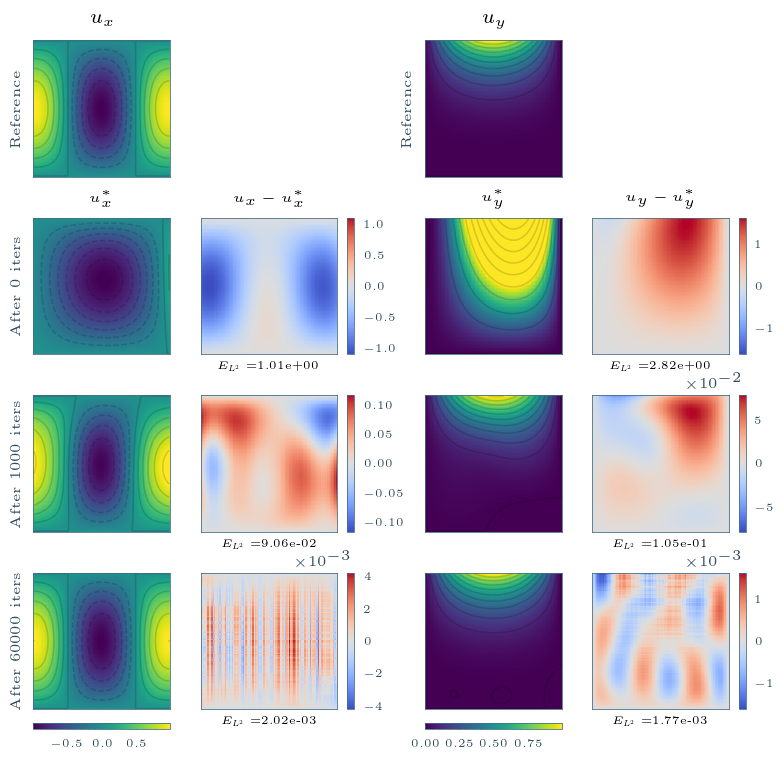

In [7]:
# === Field Evolution Plot (Ux, Uy at different iterations) ===
from phd.plot.plot_util import plot_field_evolution

book_compact_config.set_as_current()
run_to_plot_evolution = "spinn_mixed"
iterations_to_plot = [0, 1000, 60000]  # Iterations to visualize

if run_to_plot_evolution in results_forward:
    # Extract fields at specified iterations
    data = ap.extract_fields_at_iterations(
        results_forward[run_to_plot_evolution], 
        iterations_to_plot, 
        field_names=["Ux", "Uy"]
    )
    
    # Create field evolution plot
    field_titles = {"Ux": r"$u_x$", "Uy": r"$u_y$"}
    row_labels = [f"After {it} iters" for it in data["iterations"]]  # Use requested iterations
    
    # Create figure with custom size to accommodate colorbars
    n_fields = 2
    n_iters = len(iterations_to_plot)
    n_rows = 1 + n_iters
    n_cols = 2 * n_fields
    
    page_width = plt_cfg().page_width 
    fig_width = page_width
    fig_height = fig_width * (n_rows / n_cols) *0.92
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), dpi=200, gridspec_kw={'wspace': 0.35, 'hspace': 0.3})
    # plt.tight_layout(pad=1.5)  # Call tight_layout before adding colorbars
    
    fig_evo, ax_evo = plot_field_evolution(
        data["X"], data["Y"],
        data["exact"],
        data["pred"],
        data["iterations"],
        field_names=["Ux", "Uy"],
        field_titles=field_titles,
        row_labels=row_labels,
        fig=fig,
        ax=ax,
        cmap_field='viridis',
        cmap_residual='coolwarm',
        show_l2_error=True,
        plot_contours=True,
        shift_left=-0.03,  # Shift left columns slightly leftwards
    )
    
    if save_fig:
        figure_folder = "./images"
        os.makedirs(figure_folder + "/pdf", exist_ok=True)
        figure_name = f"field_evolution_{run_to_plot_evolution}"
        fig_evo.savefig(os.path.join(figure_folder, figure_name + ".png"), bbox_inches='tight', dpi=300)
        fig_evo.savefig(os.path.join(figure_folder, "pdf", figure_name + ".pdf"), bbox_inches='tight')
        print(f"Figure of size {fig_width/page_width} x page width saved at {os.path.join(figure_folder, figure_name + ".png")} + /pdf/.pdf")
else:
    print(f"Run '{run_to_plot_evolution}' not found in results_inverse")

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [8]:
# === Inverse Problem: SPINN/PINN × mixed/displacement + PINN enhanced ===
from phd.config import apply_overrides

# Run configurations to train (empty list = load all from disk)
configs_to_run_inverse = [] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]

# Load base config
base_cfg_inverse = load_config("analytical_plate")
base_cfg_inverse.task.type = "inverse"
base_cfg_inverse.training.n_iter = 60000
base_cfg_inverse.training.log_every = 200
base_cfg_inverse.seed = 0

# Define model variants (only the differences from base)
model_variants_inverse = {
    "spinn_mixed_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp_inv": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_enhanced_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],
        "model.architecture.width": 36,
        "task.inverse.training_factors.lmbd": 0.05,
        "task.inverse.training_factors.mu": 0.05,
    },
}

all_config_names_inverse = list(model_variants_inverse.keys())
results_inverse = {}

# Text labels for plotting
config_text_dict_inverse = {
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (displacement)",
    "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (displacement)",
    "pinn_enhanced_inv": "PINN (enhanced)",
}

# === Train or Load each configuration ===
for config_name in all_config_names_inverse:
    run_name = config_name
    should_train = config_name in configs_to_run_inverse
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg_inverse)
        apply_overrides(cfg, model_variants_inverse[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_inverse[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_inverse[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed_inv
Loading: spinn_disp_inv
Loading: pinn_mixed_inv
Loading: pinn_disp_inv
Loading: pinn_enhanced_inv


Figure of width 1.00 x page width saved at ./images/analytical_plate_spinn_mixed_inv.png + /pdf/.pdf


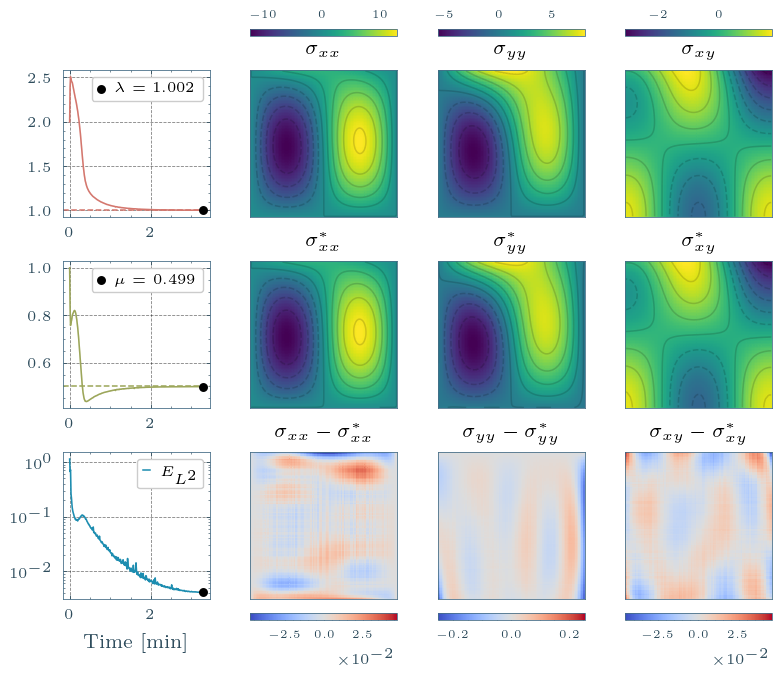

In [9]:
# === Plot single inverse run results ===
run_to_plot = "spinn_mixed_inv"  # Change to plot different configs

if run_to_plot in results_inverse:
    step = len(results_inverse[run_to_plot]["losshistory"].steps) - 2
    
    # Manually create figure with desired size and layout
    fields = ["Sxx", "Syy", "Sxy"]
    show_metrics = True
    show_residual = True
    n_rows = 2 + int(show_residual)
    n_cols = int(show_metrics) + len(fields)
    
    page_width = plt_cfg().page_width
    fig_width = page_width * (n_cols / 4)
    fig_height = fig_width * n_rows / n_cols * 0.97
    fig_inv, ax_inv = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), dpi=200, gridspec_kw={'wspace': 0.1, 'hspace': 0.3})
    
    # Pass custom figure to plot_results
    fig_inv, artists_inv = ap.plot_results(
        results_inverse[run_to_plot], 
        iteration=step, 
        fig=fig_inv, 
        ax=ax_inv,
        step_type="time", 
        time_unit="min", 
        plot_contours=True, 
        fields=fields,
        show_metrics=show_metrics,
        show_residual=show_residual,
    )

    if save_fig:
        figure_folder = "./images"
        os.makedirs(figure_folder+"/pdf", exist_ok=True) 
        figure_name = f"analytical_plate_{run_to_plot}"
        fig_inv.savefig(os.path.join(figure_folder, figure_name + ".png"), bbox_inches='tight', dpi=300)
        fig_inv.savefig(os.path.join(figure_folder, "pdf", figure_name + ".pdf"), bbox_inches='tight')
        print(f"Figure of width {fig_inv.get_size_inches()[0]/plt_cfg().page_width:.2f} x page width saved at {os.path.join(figure_folder, figure_name+ ".png")} + /pdf/.pdf")

else:
    print(f"Run '{run_to_plot}' not found in results_inverse")